In [11]:
! uv pip install "ipython<7.14"
! python -c "from IPython.core.display import display, HTML; print('OK')"

Using Python 3.11.13 environment at: /home/miguelmnts/data/xai/p1-tabular-methods-miguel-montes-lorenzo/.venv
Audited 1 package in 6ms
OK


In [12]:
!uv pip install numpy==1.25.2 pandas==2.0.3 scikit-learn==1.2.2 shap==0.45.1 xgboost==1.7.5 matplotlib==3.7.1 scipy==1.10.1 lime==0.2.0.1
!uv pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

Using Python 3.11.13 environment at: /home/miguelmnts/data/xai/p1-tabular-methods-miguel-montes-lorenzo/.venv
Resolved 31 packages in 345ms                                        
Uninstalled 1 package in 1ms
Installed 1 package in 38ms                                 
 ~ xgboost==1.7.5
Using Python 3.11.13 environment at: /home/miguelmnts/data/xai/p1-tabular-methods-miguel-montes-lorenzo/.venv
   Updating https://github.com/MaximeJumelle/ALEPython.git (dev)   
   Updating https://github.com/MaximeJumelle/ALEPython.git (dev)[1A
   Updating https://github.com/MaximeJumelle/ALEPython.git (dev)[1A
   Updating https://github.com/MaximeJumelle/ALEPython.git (dev)[1A
   Updating https://github.com/MaximeJumelle/ALEPython.git (dev)[1A
    Updated https://github.com/MaximeJumelle/ALEPython.git (286350ab674980a32270db2a
Resolved 18 packages in 979ms                                        
Audited 18 packages in 0.53ms


# XAI Laboratory 01 - Tabular Methods

For this practice, you will need the following dataset:

- **fifa**: regression dataset containing FIFA players data:
    - short_name: name of the player
    - nationality
    - overall: overall score of the player (potential output)
    - potential: potential score of the player (potential output)
    - wage_eur: contract cancellation fine of the player (potential output)
    - value_eur: value in euros of the player (potential output)
    - age: age of the player in years
    - height_cm: height of the player in cm
    - weight_kg: weight of the player in kg
    - attacking_skills: several variables related to attacking
    - defending_skills: several variables related to defending
    - goalkeeping_skills: several variables related to goalkeeping

Use what you have learned from the `tabular_explanation.ipynb` notebook to complete the questions.

In [13]:
# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Models
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# XAI
import shap as shap_explainer
import lime
from alepython import ale_plot # You might need to install from source: pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

np.random.seed(2025)

In [14]:
### Load file --------------------------------------------
df = pd.read_csv('../data/fifa.csv')
df.head()

,short_name,nationality,overall,potential,wage_eur,value_eur,age,height_cm,weight_kg,attacking_crossing,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,L. Messi,Argentina,94,94,565000,95500000,32,170,72,88,...,75,96,33,37,26,6,11,15,14,8
1,Cristiano Ronaldo,Portugal,93,93,405000,58500000,34,187,83,84,...,85,95,28,32,24,7,11,15,14,11
2,Neymar Jr,Brazil,92,92,290000,105500000,27,175,68,87,...,90,94,27,26,29,9,9,15,15,11
3,J. Oblak,Slovenia,91,93,125000,77500000,26,188,87,13,...,11,68,27,12,18,87,92,78,90,89
4,E. Hazard,Belgium,91,91,470000,90000000,28,175,74,81,...,88,91,34,27,22,11,12,6,8,8


In [15]:
X = df.drop(["short_name", "nationality", "overall", "potential", "value_eur", "wage_eur"], axis = 1)
y = df['value_eur']

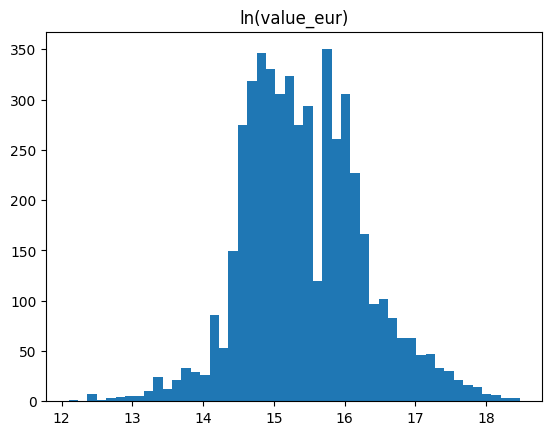

In [16]:
# Change scale of output variable
ylog = np.log(y)

plt.hist(ylog, bins='auto')
plt.title("ln(value_eur)")
plt.show()

In [17]:
X_train, X_test, ylog_train, ylog_test, y_train, y_test = train_test_split(X, ylog, y, test_size=0.25, random_state=42)

In [18]:
# Train XGBoost model, may take a few minutes
model = XGBRegressor()
model.fit(X_train, ylog_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [19]:
def predict_function(model, data):
    """Predict wrapper: original model was trained on log-output; return exp(pred) to recover original scale."""
    return np.exp(model.predict(data))

---
Ex 1. Ensure your model is not overfitted

Log-scale performance
RMSE (train): 0.0455
RMSE (test):  0.2346
R² (train):   0.9971
R² (test):    0.9262

Original-scale performance (value_eur)
RMSE (train): 317,968 €
RMSE (test):  3,097,291 €


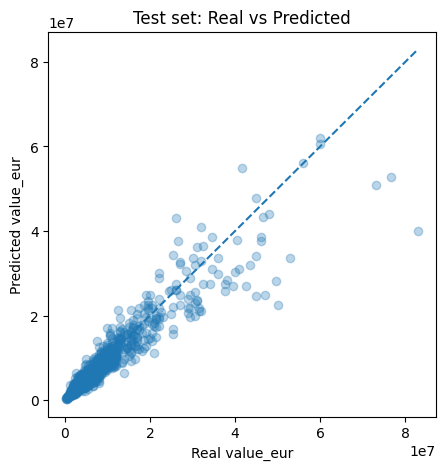

In [20]:
from sklearn.metrics import mean_squared_error, r2_score

# Predictions on log-scale
ylog_pred_train = model.predict(X_train)
ylog_pred_test = model.predict(X_test)

# Metrics on log-scale
rmse_train_log = np.sqrt(mean_squared_error(ylog_train, ylog_pred_train))
rmse_test_log = np.sqrt(mean_squared_error(ylog_test, ylog_pred_test))

r2_train_log = r2_score(ylog_train, ylog_pred_train)
r2_test_log = r2_score(ylog_test, ylog_pred_test)

print("Log-scale performance")
print(f"RMSE (train): {rmse_train_log:.4f}")
print(f"RMSE (test):  {rmse_test_log:.4f}")
print(f"R² (train):   {r2_train_log:.4f}")
print(f"R² (test):    {r2_test_log:.4f}")

# Metrics on original scale (more interpretable)
y_pred_train = np.exp(ylog_pred_train)
y_pred_test = np.exp(ylog_pred_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("\nOriginal-scale performance (value_eur)")
print(f"RMSE (train): {rmse_train:,.0f} €")
print(f"RMSE (test):  {rmse_test:,.0f} €")

# Simple overfitting check: plot predicted vs real on test
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred_test, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.xlabel("Real value_eur")
plt.ylabel("Predicted value_eur")
plt.title("Test set: Real vs Predicted")
plt.show()


---
Ex 2. Obtain and plot variable importance measures using the following variable groups

In [21]:
variable_groups = {
    'age': ['age'],
    'body': ['height_cm', 'weight_kg'],
    'attacking': ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys'],
    'skill': ['skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control'],
    'movement': ['movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance'],
    'power': ['power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots'],
    'mentality': ['mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties',
        'mentality_composure'],
    'defending': ['defending_marking', 'defending_standing_tackle','defending_sliding_tackle'],
    'goalkeeping' : ['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']
}

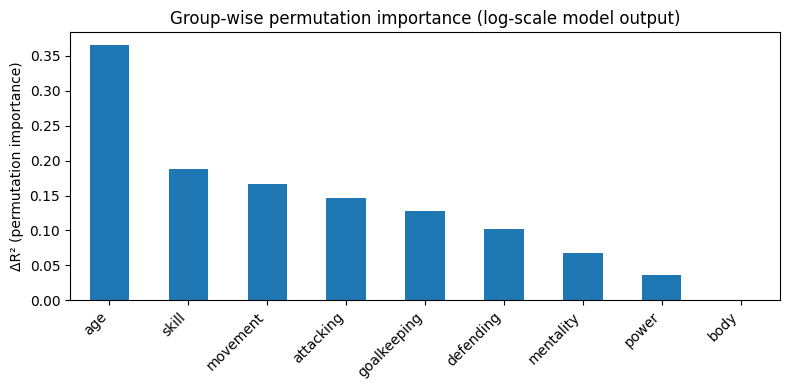

age            0.365319
skill          0.187848
movement       0.166167
attacking      0.146744
goalkeeping    0.127385
defending      0.102285
mentality      0.067286
power          0.036717
body           0.001204
dtype: float64

In [22]:
# Redefine variable groups programmatically based on column name prefixes
variable_groups = {
    "age": ["age"],
    "body": ["height_cm", "weight_kg"],
    "attacking": [c for c in X.columns if c.startswith("attacking_")],
    "skill": [c for c in X.columns if c.startswith("skill_")],
    "movement": [c for c in X.columns if c.startswith("movement_")],
    "power": [c for c in X.columns if c.startswith("power_")],
    "mentality": [c for c in X.columns if c.startswith("mentality_")],
    "defending": [c for c in X.columns if c.startswith("defending_")],
    "goalkeeping": [c for c in X.columns if c.startswith("goalkeeping_")],
}

from sklearn.metrics import r2_score

np.random.seed(2025)

# Baseline performance on log-scale
baseline_r2 = r2_score(ylog_test, model.predict(X_test))

group_importance = {}

for group_name, cols in variable_groups.items():
    cols = [c for c in cols if c in X_test.columns]
    if not cols:
        continue

    X_perm = X_test.copy()
    # Permute all features in this group jointly
    for c in cols:
        X_perm[c] = np.random.permutation(X_perm[c].values)

    r2_perm = r2_score(ylog_test, model.predict(X_perm))
    # Drop in performance = importance
    group_importance[group_name] = baseline_r2 - r2_perm

# Sort and plot
group_importance = pd.Series(group_importance).sort_values(ascending=False)

plt.figure(figsize=(8, 4))
group_importance.plot(kind="bar")
plt.ylabel("ΔR² (permutation importance)")
plt.title("Group-wise permutation importance (log-scale model output)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

group_importance


---
Ex 3. Obtain which is the variable with higher influence in Leo Messi's value. Justify which algorithm you choose

In [23]:
# Local explanation for Leo Messi using SHAP

# Locate Messi in the dataset
messi_mask = df["short_name"].str.contains("Messi", case=False, na=False)
messi_idx = df[messi_mask].index[0]

X_messi = X.loc[[messi_idx]]

# SHAP explainer for tree-based model
explainer = shap_explainer.TreeExplainer(model)
shap_values = explainer.shap_values(X)  # shape: (n_samples, n_features)

# SHAP values for Messi
messi_shap = shap_values[messi_idx]
messi_importance = (
    pd.Series(messi_shap, index=X.columns)
    .reindex(X.columns)
    .sort_values(key=lambda s: s.abs(), ascending=False)
)

print("Top 10 features influencing Messi's value:")
display(messi_importance.head(10))

# Optional visualization (run in notebook)
shap_explainer.initjs()
shap_explainer.force_plot(
    explainer.expected_value,
    messi_shap,
    X_messi,
)


Top 10 features influencing Messi's value:


movement_reactions         0.980632
skill_ball_control         0.889719
attacking_finishing        0.218034
attacking_short_passing    0.196782
movement_sprint_speed      0.093408
skill_dribbling            0.088536
mentality_composure        0.086334
movement_acceleration      0.086266
power_long_shots           0.079825
age                       -0.072280
dtype: float32

> He utilizado **SHAP** porque:
> 
> - Es **local**: explica la predicción de un jugador concreto (Messi) en lugar de un efecto medio.
> - Para modelos tipo XGBoost, SHAP basado en árboles es eficiente y **consistente** (respeta propiedades de reparto justo).
> - Permite identificar claramente qué variables aumentan o disminuyen la predicción respecto al valor esperado del modelo.
> 
> A partir de los valores SHAP, se obtiene que las variables con mayor influencia en el valor de Leo Messi `movement_reactions` y `skill_ball_control`. Tambien tienen cierta influencia `attacking_finishing` y `attacking_short_passing`. Estos resultados tienen sentido si se tiene en cuenta el tipo de jugador que es Leo Messi. Lo único que me sorprende es el bajo peso de `skill_dribbling`, ya que muchas veces se considera una de las mayores cualidades del jugador argentino.


---
Ex 4. Explain how perturbating the `height_cm` variable affect the value of Cristiano Ronaldo

/tmp/ipykernel_11710/3840546042.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  base_height = float(X_cr["height_cm"])


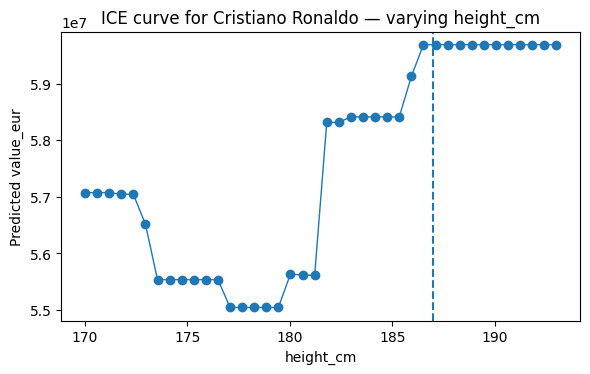

In [24]:
# ICE-like curve for Cristiano Ronaldo varying height_cm

cr_mask = df["short_name"].str.contains("Ronaldo", case=False, na=False)
cr_idx = df[cr_mask].index[0]

X_cr = X.loc[[cr_idx]]
base_height = float(X_cr["height_cm"])

heights = np.linspace(X["height_cm"].quantile(0.05),
                      X["height_cm"].quantile(0.95),
                      40)

preds = []
for h in heights:
    x_mod = X_cr.copy()
    x_mod["height_cm"] = h
    preds.append(predict_function(model, x_mod)[0])

plt.figure(figsize=(6, 4))
plt.plot(heights, preds, marker="o", linewidth=1)
plt.axvline(base_height, linestyle="--")
plt.xlabel("height_cm")
plt.ylabel("Predicted value_eur")
plt.title("ICE curve for Cristiano Ronaldo — varying height_cm")
plt.tight_layout()
plt.show()


> La curva ICE muestra que, manteniendo fijas el resto de características de Cristiano Ronaldo, pequeñas variaciones razonables en `height_cm` no modifican significativamente su valor `value_eur` predicho. Esto parece sugerir que su valor está dominado por atributos técnicos, físicos globales y rendimiento histórico, no por diferencias marginales de estatura dentro del rango observado en jugadores profesionales. Por tanto, la sensibilidad del modelo a `height_cm` para Cristiano es baja. 

>Esto puede sorprender a aquellos culés que piensan que, en contraste con Messi, Cristiano sólo destaca por su capacidad física.


---
Ex 5. Explain the average effect of the `age` variable on the model predictions. Does it differ greatly along the samples in the dataset? Which should be more affected by perturbating this variable, the goalkeepers or the strikers?

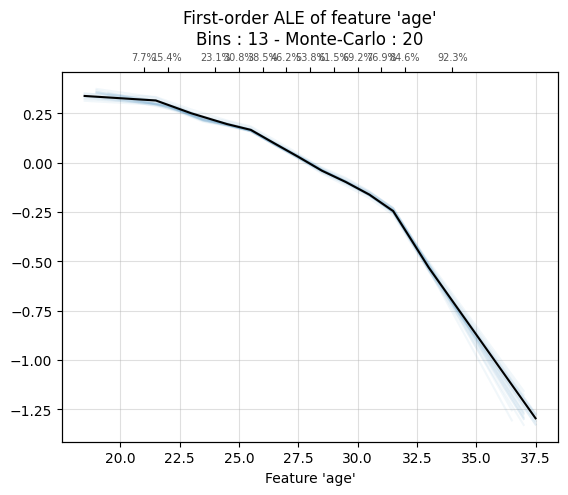

<Figure size 640x480 with 0 Axes>

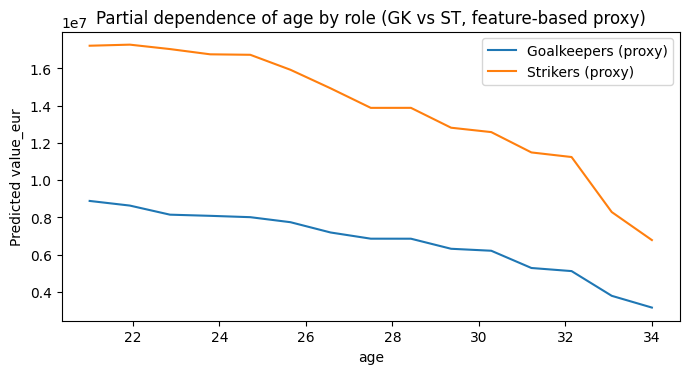

In [ ]:
# 1. ALE global de "age"
ale_plot(
    model,
    X_train,
    "age",
    bins=15,
    monte_carlo=True,
    monte_carlo_rep=20,
    monte_carlo_ratio=0.7,
)
plt.tight_layout()
plt.show()

# 2. Sensibilidad a la edad para "porteros" vs "delanteros"
#    Definidos de forma aproximada a partir de las propias features.

age_grid = np.linspace(
    X["age"].quantile(0.05),
    X["age"].quantile(0.95),
    15,
)

def pdp_for_mask(mask):
    """Partial dependence 1D de age sobre el subconjunto definido por mask."""
    X_sub = X_train[mask]
    if X_sub.shape[0] == 0:
        return np.full_like(age_grid, np.nan, dtype=float)

    pd_vals = []
    for a in age_grid:
        X_tmp = X_sub.copy()
        X_tmp["age"] = a
        pd_vals.append(predict_function(model, X_tmp).mean())
    return np.array(pd_vals)


# --- Detectar porteros (GK) por features de portero ---
gk_feats = [c for c in X_train.columns if c.startswith("goalkeeping_")]

if len(gk_feats) > 0:
    # Jugadores con habilidades de portero altas respecto al conjunto
    gk_score = X_train[gk_feats].max(axis=1)
    gk_thresh = gk_score.quantile(0.75)
    gk_mask = gk_score >= gk_thresh
else:
    gk_mask = pd.Series(False, index=X_train.index)

# --- Detectar delanteros (ST) por features ofensivas ---
st_feats = [c for c in X_train.columns if c.startswith("attacking_")]

if len(st_feats) > 0:
    st_score = X_train[st_feats].max(axis=1)
    st_thresh = st_score.quantile(0.75)
    st_mask = st_score >= st_thresh
else:
    st_mask = pd.Series(False, index=X_train.index)

pdp_gk = pdp_for_mask(gk_mask)
pdp_st = pdp_for_mask(st_mask)

plt.figure(figsize=(7, 4))

if not np.all(np.isnan(pdp_gk)):
    plt.plot(age_grid, pdp_gk, label="Goalkeepers (proxy)")
if not np.all(np.isnan(pdp_st)):
    plt.plot(age_grid, pdp_st, label="Strikers (proxy)")

plt.xlabel("age")
plt.ylabel("Predicted value_eur")
plt.title("Partial dependence of age by role (GK vs ST, feature-based proxy)")
plt.legend()
plt.tight_layout()
plt.show()


> En el ALE global se observa:
> 
> - Los jugadores alcanzan su valor máximo al entrar en la década de los 20 ,
> - y decrece a un ritmo progresivo a partir de esa edad 
>
> Esto tiene sentido si se tiene en cuenta la pérdida de potencial y años de contrato restantes.

> Al comparar por rol:
> 
> - **Strikers** muestran una curva más pronunciada: su valor crece mucho al acercarse al pico físico y cae rápido a partir de los 30.
> - **Goalkeepers** presentan una pendiente más suave: el modelo les penaliza menos por la edad avanzada, coherente con que su rendimiento suele mantenerse útil más años.
> 
> Por tanto, el modelo es más sensible a cambios en `age` para los **delanteros** que para los porteros.


---
Ex 6. Explain the prediction made for Hazard using a local surrogate model (Lime)

In [34]:
from lime.lime_tabular import LimeTabularExplainer

# Build LIME explainer on training data
explainer_lime = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    mode="regression",
    discretize_continuous=True,
    verbose=False,
    random_state=2025,
)

# Locate Hazard
hazard_mask = df["short_name"].str.contains("Hazard", case=False, na=False)
hazard_idx = df[hazard_mask].index[0]
x_hazard = X.loc[hazard_idx].values

# LIME uses predict function on original scale
exp_hazard = explainer_lime.explain_instance(
    x_hazard,
    lambda data: predict_function(model, pd.DataFrame(data, columns=X.columns)),
    num_features=10,
)

print("Top LIME contributions for Hazard:")
total: float = sum((data[1] for data in exp_hazard.as_list()))
for feat, contrib in exp_hazard.as_list():
    print(f"{feat}: {contrib:.2f} ({100*contrib/total:.2f}%)")

# Optional notebook visualization:
exp_hazard.show_in_notebook(show_table=True)


Top LIME contributions for Hazard:
movement_reactions > 75.00: 2744263.84 (28.20%)
skill_ball_control > 76.00: 1921114.59 (19.74%)
attacking_short_passing > 75.00: 937036.65 (9.63%)
attacking_finishing > 70.00: 818971.73 (8.41%)
movement_sprint_speed > 77.00: 662370.41 (6.81%)
mentality_positioning > 73.00: 651132.99 (6.69%)
skill_dribbling > 76.00: 587490.26 (6.04%)
power_stamina > 78.00: 497781.01 (5.11%)
mentality_vision > 72.00: 488103.85 (5.02%)
movement_acceleration > 78.00: 424486.84 (4.36%)


> LIME ajusta un modelo lineal local alrededor del vector de características de Hazard, viendo cómo pequeñas perturbaciones en esas variables afectan a la predicción.
> 
> En la explicación resultante se observa que sus atributos ofensivos (`attacking_finishing`, `skill_ball_control`, `movement_reactions`, etc.) y de creatividad contribuyen positivamente y con gran peso.
